In [70]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from scipy import sparse
import time

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from tqdm import tqdm

from torch_lr_finder import LRFinder

import utils
from importlib import reload

reload(utils)

<module 'utils' from '/home/artemy/multimodal_proj/nb/utils.py'>

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
else:
    device = torch.device("cpu")

Using GPU


## Files

In [3]:
DATASET = 'cite'

data_dir = '/home/artemy/multimodal_proj/data/competition/'
log_dir = '/home/artemy/multimodal_proj/cur_model_tb'
o_dir = '/home/artemy/multimodal_proj/data/AE_predictions/'


if DATASET == 'multi':
    inputs_train_fn = data_dir + "atac_train_raw.sparse.npz"
    targets_train_fn = data_dir + "gex_train.sparse.npz"
    inputs_test_fn = data_dir + "atac_test_raw.sparse.npz"
    pred_file = o_dir + "multi_gex_pred.npy"
elif DATASET == 'cite':
    inputs_train_fn = data_dir + "cite_gex_train.sparse.npz"
    targets_train_fn = data_dir + "cite_adt_train.sparse.npz"
    inputs_test_fn = data_dir + "cite_gex_test.sparse.npz"
    pred_file = o_dir + "cite_adt_pred.npy"


## Model:

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0) 
            
class CustomModel(nn.Module, utils.HyperParameters):
    def dist_loss(self, y, y_hat):
        gausshist = GaussianHistogram(bins=20, min=5, max=25, sigma=6)
        dist1 = gausshist(y.flatten())[1:]
        dist2 = gausshist(y_hat.flatten())[1:]
        dist1 += 1
        dist2 += 1
        dist1 /= torch.sum(dist1)
        dist2 /= torch.sum(dist2)
        l = nn.KLDivLoss(reduction="batchmean", log_target=True)(torch.log(dist1), torch.log(dist2))
        return l
    
    def MSE_loss(self, y, y_hat):
        l = nn.MSELoss()(y_hat, y)
        return l
    
    def cor_loss(self, y, y_hat):
        r = torch.corrcoef(torch.stack((y.flatten(), y_hat.flatten())))[0, 1]
        return -r
    
    def loss(self, y, y_hat):
        l = 0
        l += self.MSE_loss(y, y_hat)
        #l += self.cor_loss(y, y_hat)
        return l
    
    def kl_divergence(self, rho, rho_hat):
        rho_hat = torch.mean(torch.sigmoid(rho_hat), 1) # sigmoid because we need the probability distributions
        rho = torch.tensor([rho] * len(rho_hat)).to(device)
        return torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)))
    

    def training_step(self, inputs, targets, calculate_cor=True):
        rna_recon, klloss = self.forward(inputs)
        loss_rna = self.loss(rna_recon, targets)
        loss = loss_rna + klloss * self.beta
        
        if calculate_cor:
            cor = utils.spearman_cor(rna_recon, targets)
        else:
            cor=0
        return _, loss, cor
    
    def validation_step(self, inputs, targets, calculate_cor=True):
        rna_recon, klloss = self.forward(inputs)
        loss_rna = self.loss(rna_recon, targets)
        loss = loss_rna + klloss * self.beta
        
        if calculate_cor:
            cor = utils.spearman_cor(rna_recon, targets)
        else:
            cor=0
        return _, loss, cor
    
    def predict(self, inputs):
        rna_recon, klloss = self.forward(inputs)
        return rna_recon

In [58]:
class MLP_Multi(CustomModel):
    def __init__(self,
                input_dim: int,
                output_dim: int,
                rho=0.05,
                beta=0.001
    ):
        super().__init__()
        self.save_hyperparameters()
        
        
        modules = []
        input_dim = self.input_dim
        output_dim = 2000
        self.l1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(num_features=output_dim)          
        self.act1 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = 2000
        self.l2 = nn.Linear(input_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(num_features=output_dim)          
        self.act2 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = 2000
        self.l3 = nn.Linear(input_dim, output_dim)
        self.bn3 = nn.BatchNorm1d(num_features=output_dim)           
        self.act3 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = 2000
        self.l4 = nn.Linear(input_dim, output_dim)
        self.bn4 = nn.BatchNorm1d(num_features=output_dim)           
        self.act4 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = self.output_dim
        self.l5 = nn.Linear(input_dim, output_dim)
        #self.bn4 = nn.BatchNorm1d(num_features=output_dim)            
        #self.act4 = nn.SiLU()
        

            
        self.net = nn.Sequential(self.l1, self.bn1, self.act1,
                                 self.l2, self.bn2, self.act2,
                                 self.l3, self.bn3, self.act3,
                                 self.l4, self.bn4, self.act4,
                                 self.l5) 
        self.net.apply(init_weights)
    
    def forward(self, x):

        out = self.l1(x)
        out = self.bn1(out)
        out1 = self.act1(out)
        
        out = self.l2(out1)
        out = self.bn2(out)
        out2 = self.act2(out)
        
        out = self.l3(out2)
        out = self.bn3(out)
        out3 = self.act3(out)
        
        out = self.l4(out3)
        out = self.bn4(out)
        out4 = self.act4(out)
        
        #out = torch.concat((out1, out2, out3, out4), 1)
                
        out = self.l5(out4)

        
        klloss = 0
        for vals in [out1, out2, out3, out4]:
                klloss += self.kl_divergence(self.rho, vals)
            
        return out, klloss

In [ ]:
class MLP_Cite(CustomModel):
    def __init__(self,
                input_dim: int,
                output_dim: int,
                rho=0.05,
                beta=0.001
    ):
        super().__init__()
        self.save_hyperparameters()
        
        
        modules = []
        input_dim = self.input_dim
        output_dim1 = 512
        self.l1 = nn.Linear(input_dim, output_dim1)
        self.bn1 = nn.BatchNorm1d(num_features=output_dim1)          
        self.act1 = nn.SiLU()
        
        input_dim = output_dim1
        output_dim2 = 512 
        self.l2 = nn.Linear(input_dim, output_dim2)
        self.bn2 = nn.BatchNorm1d(num_features=output_dim2)          
        self.act2 = nn.SiLU()
        
        input_dim = output_dim2
        output_dim3 = 512 
        self.l3 = nn.Linear(input_dim, output_dim3)
        self.bn3 = nn.BatchNorm1d(num_features=output_dim3)           
        self.act3 = nn.SiLU()
        
        input_dim = output_dim3
        output_dim4 = 512 
        self.l4 = nn.Linear(input_dim, output_dim4)
        self.bn4 = nn.BatchNorm1d(num_features=output_dim4)           
        self.act4 = nn.SiLU()
        
        input_dim = output_dim1 + output_dim2 + output_dim3 + output_dim4
        output_dim5 = self.output_dim
        self.l5 = nn.Linear(input_dim, output_dim5)
        #self.bn5 = nn.BatchNorm1d(num_features=output_dim)            
        #self.act5 = nn.SiLU()
        
        #input_dim = output_dim
        #output_dim = self.output_dim
        #self.l6 = nn.Linear(input_dim, output_dim)
        

            
        self.net = nn.Sequential(self.l1, self.bn1, self.act1,
                                 self.l2, self.bn2, self.act2,
                                 self.l3, self.bn3, self.act3,
                                 self.l4, self.bn4, self.act4,
                                 self.l5) 
        self.net.apply(init_weights)
    
    def forward(self, x):

        out = self.l1(x)
        out = self.bn1(out)
        out1 = self.act1(out)
        
        out = self.l2(out1)
        out = self.bn2(out)
        out2 = self.act2(out)
        
        out = self.l3(out2)
        out = self.bn3(out)
        out3 = self.act3(out)
        
        out = self.l4(out3)
        out = self.bn4(out)
        out4 = self.act4(out)
        
        out = torch.concat((out1, out2, out3, out4), 1)
                
        out = self.l5(out)
        #out = self.bn5(out)
        #out = self.act5(out)
        
        #out = self.l6(out)

        
        klloss = 0
        #for vals in [out1, out2, out3, out4]:
        #        klloss += self.kl_divergence(self.rho, vals)
            
        return out, klloss

## Load data

In [6]:
load_data = 1
if load_data:
    inputs = utils.load_sparse_data(inputs_train_fn)
    imputed_inputs = utils.load_sparse_data(data_dir + "cite_gex_train_magic.sparse.npz")
    targets = utils.load_sparse_data(targets_train_fn)

    inputs_test = utils.load_sparse_data(inputs_test_fn)
    imputed_inputs_test = utils.load_sparse_data(data_dir + "cite_gex_test_magic.sparse.npz")


In [8]:
from sklearn.decomposition import TruncatedSVD, NMF, PCA, KernelPCA

constant_cols = ['ENSG00000003137_CYP26B1', 'ENSG00000004848_ARX', 'ENSG00000006606_CCL26', 'ENSG00000010379_SLC6A13', 'ENSG00000010932_FMO1', 'ENSG00000017427_IGF1', 'ENSG00000022355_GABRA1', 'ENSG00000041982_TNC', 'ENSG00000060709_RIMBP2', 'ENSG00000064886_CHI3L2', 'ENSG00000065717_TLE2', 'ENSG00000067798_NAV3', 'ENSG00000069535_MAOB', 'ENSG00000073598_FNDC8', 'ENSG00000074219_TEAD2', 'ENSG00000074964_ARHGEF10L', 'ENSG00000077264_PAK3', 'ENSG00000078053_AMPH', 'ENSG00000082684_SEMA5B', 'ENSG00000083857_FAT1', 'ENSG00000084628_NKAIN1', 'ENSG00000084734_GCKR', 'ENSG00000086967_MYBPC2', 'ENSG00000087258_GNAO1', 'ENSG00000089505_CMTM1', 'ENSG00000091129_NRCAM', 'ENSG00000091986_CCDC80', 'ENSG00000092377_TBL1Y', 'ENSG00000092969_TGFB2', 'ENSG00000095397_WHRN', 'ENSG00000095970_TREM2', 'ENSG00000099715_PCDH11Y', 'ENSG00000100197_CYP2D6', 'ENSG00000100218_RSPH14', 'ENSG00000100311_PDGFB', 'ENSG00000100362_PVALB', 'ENSG00000100373_UPK3A', 'ENSG00000100625_SIX4', 'ENSG00000100867_DHRS2', 'ENSG00000100985_MMP9', 'ENSG00000101197_BIRC7', 'ENSG00000101298_SNPH', 'ENSG00000102387_TAF7L', 'ENSG00000103034_NDRG4', 'ENSG00000104059_FAM189A1', 'ENSG00000104112_SCG3', 'ENSG00000104313_EYA1', 'ENSG00000104892_KLC3', 'ENSG00000105088_OLFM2', 'ENSG00000105261_OVOL3', 'ENSG00000105290_APLP1', 'ENSG00000105507_CABP5', 'ENSG00000105642_KCNN1', 'ENSG00000105694_ELOCP28', 'ENSG00000105707_HPN', 'ENSG00000105894_PTN', 'ENSG00000106018_VIPR2', 'ENSG00000106541_AGR2', 'ENSG00000107317_PTGDS', 'ENSG00000108688_CCL7', 'ENSG00000108702_CCL1', 'ENSG00000108947_EFNB3', 'ENSG00000109193_SULT1E1', 'ENSG00000109794_FAM149A', 'ENSG00000109832_DDX25', 'ENSG00000110195_FOLR1', 'ENSG00000110375_UPK2', 'ENSG00000110436_SLC1A2', 'ENSG00000111339_ART4', 'ENSG00000111863_ADTRP', 'ENSG00000112761_WISP3', 'ENSG00000112852_PCDHB2', 'ENSG00000114251_WNT5A', 'ENSG00000114279_FGF12', 'ENSG00000114455_HHLA2', 'ENSG00000114757_PEX5L', 'ENSG00000115155_OTOF', 'ENSG00000115266_APC2', 'ENSG00000115297_TLX2', 'ENSG00000115590_IL1R2', 'ENSG00000115844_DLX2', 'ENSG00000116194_ANGPTL1', 'ENSG00000116661_FBXO2', 'ENSG00000116774_OLFML3', 'ENSG00000117322_CR2', 'ENSG00000117971_CHRNB4', 'ENSG00000118322_ATP10B', 'ENSG00000118402_ELOVL4', 'ENSG00000118520_ARG1', 'ENSG00000118946_PCDH17', 'ENSG00000118972_FGF23', 'ENSG00000119771_KLHL29', 'ENSG00000120549_KIAA1217', 'ENSG00000121316_PLBD1', 'ENSG00000121905_HPCA', 'ENSG00000122224_LY9', 'ENSG00000124194_GDAP1L1', 'ENSG00000124440_HIF3A', 'ENSG00000124657_OR2B6', 'ENSG00000125462_C1orf61', 'ENSG00000125895_TMEM74B', 'ENSG00000126838_PZP', 'ENSG00000128422_KRT17', 'ENSG00000128918_ALDH1A2', 'ENSG00000129170_CSRP3', 'ENSG00000129214_SHBG', 'ENSG00000129673_AANAT', 'ENSG00000129910_CDH15', 'ENSG00000130294_KIF1A', 'ENSG00000130307_USHBP1', 'ENSG00000130545_CRB3', 'ENSG00000131019_ULBP3', 'ENSG00000131044_TTLL9', 'ENSG00000131183_SLC34A1', 'ENSG00000131386_GALNT15', 'ENSG00000131400_NAPSA', 'ENSG00000131914_LIN28A', 'ENSG00000131941_RHPN2', 'ENSG00000131951_LRRC9', 'ENSG00000132170_PPARG', 'ENSG00000132681_ATP1A4', 'ENSG00000132958_TPTE2', 'ENSG00000133454_MYO18B', 'ENSG00000134545_KLRC1', 'ENSG00000134853_PDGFRA', 'ENSG00000135083_CCNJL', 'ENSG00000135100_HNF1A', 'ENSG00000135116_HRK', 'ENSG00000135312_HTR1B', 'ENSG00000135324_MRAP2', 'ENSG00000135436_FAM186B', 'ENSG00000135472_FAIM2', 'ENSG00000135898_GPR55', 'ENSG00000135929_CYP27A1', 'ENSG00000136002_ARHGEF4', 'ENSG00000136099_PCDH8', 'ENSG00000136274_NACAD', 'ENSG00000137078_SIT1', 'ENSG00000137142_IGFBPL1', 'ENSG00000137473_TTC29', 'ENSG00000137474_MYO7A', 'ENSG00000137491_SLCO2B1', 'ENSG00000137691_CFAP300', 'ENSG00000137731_FXYD2', 'ENSG00000137747_TMPRSS13', 'ENSG00000137878_GCOM1', 'ENSG00000138411_HECW2', 'ENSG00000138741_TRPC3', 'ENSG00000138769_CDKL2', 'ENSG00000138823_MTTP', 'ENSG00000139908_TSSK4', 'ENSG00000140832_MARVELD3', 'ENSG00000142178_SIK1', 'ENSG00000142538_PTH2', 'ENSG00000142910_TINAGL1', 'ENSG00000143217_NECTIN4', 'ENSG00000143858_SYT2', 'ENSG00000144130_NT5DC4', 'ENSG00000144214_LYG1', 'ENSG00000144290_SLC4A10', 'ENSG00000144366_GULP1', 'ENSG00000144583_MARCH4', 'ENSG00000144771_LRTM1', 'ENSG00000144891_AGTR1', 'ENSG00000145087_STXBP5L', 'ENSG00000145107_TM4SF19', 'ENSG00000146197_SCUBE3', 'ENSG00000146966_DENND2A', 'ENSG00000147082_CCNB3', 'ENSG00000147614_ATP6V0D2', 'ENSG00000147642_SYBU', 'ENSG00000147869_CER1', 'ENSG00000149403_GRIK4', 'ENSG00000149596_JPH2', 'ENSG00000150630_VEGFC', 'ENSG00000150722_PPP1R1C', 'ENSG00000151631_AKR1C6P', 'ENSG00000151704_KCNJ1', 'ENSG00000152154_TMEM178A', 'ENSG00000152292_SH2D6', 'ENSG00000152315_KCNK13', 'ENSG00000152503_TRIM36', 'ENSG00000153253_SCN3A', 'ENSG00000153902_LGI4', 'ENSG00000153930_ANKFN1', 'ENSG00000154040_CABYR', 'ENSG00000154118_JPH3', 'ENSG00000154175_ABI3BP', 'ENSG00000154645_CHODL', 'ENSG00000157060_SHCBP1L', 'ENSG00000157087_ATP2B2', 'ENSG00000157152_SYN2', 'ENSG00000157168_NRG1', 'ENSG00000157680_DGKI', 'ENSG00000158246_TENT5B', 'ENSG00000158477_CD1A', 'ENSG00000158481_CD1C', 'ENSG00000158488_CD1E', 'ENSG00000159189_C1QC', 'ENSG00000159217_IGF2BP1', 'ENSG00000160683_CXCR5', 'ENSG00000160801_PTH1R', 'ENSG00000160973_FOXH1', 'ENSG00000161594_KLHL10', 'ENSG00000162409_PRKAA2', 'ENSG00000162840_MT2P1', 'ENSG00000162873_KLHDC8A', 'ENSG00000162944_RFTN2', 'ENSG00000162949_CAPN13', 'ENSG00000163116_STPG2', 'ENSG00000163288_GABRB1', 'ENSG00000163531_NFASC', 'ENSG00000163618_CADPS', 'ENSG00000163637_PRICKLE2', 'ENSG00000163735_CXCL5', 'ENSG00000163873_GRIK3', 'ENSG00000163898_LIPH', 'ENSG00000164061_BSN', 'ENSG00000164078_MST1R', 'ENSG00000164123_C4orf45', 'ENSG00000164690_SHH', 'ENSG00000164761_TNFRSF11B', 'ENSG00000164821_DEFA4', 'ENSG00000164845_FAM86FP', 'ENSG00000164867_NOS3', 'ENSG00000166073_GPR176', 'ENSG00000166148_AVPR1A', 'ENSG00000166250_CLMP', 'ENSG00000166257_SCN3B', 'ENSG00000166268_MYRFL', 'ENSG00000166523_CLEC4E', 'ENSG00000166535_A2ML1', 'ENSG00000166819_PLIN1', 'ENSG00000166928_MS4A14', 'ENSG00000167210_LOXHD1', 'ENSG00000167306_MYO5B', 'ENSG00000167634_NLRP7', 'ENSG00000167748_KLK1', 'ENSG00000167889_MGAT5B', 'ENSG00000168140_VASN', 'ENSG00000168546_GFRA2', 'ENSG00000168646_AXIN2', 'ENSG00000168955_TM4SF20', 'ENSG00000168993_CPLX1', 'ENSG00000169075_Z99496.1', 'ENSG00000169194_IL13', 'ENSG00000169246_NPIPB3', 'ENSG00000169884_WNT10B', 'ENSG00000169900_PYDC1', 'ENSG00000170074_FAM153A', 'ENSG00000170075_GPR37L1', 'ENSG00000170289_CNGB3', 'ENSG00000170356_OR2A20P', 'ENSG00000170537_TMC7', 'ENSG00000170689_HOXB9', 'ENSG00000170827_CELP', 'ENSG00000171346_KRT15', 'ENSG00000171368_TPPP', 'ENSG00000171501_OR1N2', 'ENSG00000171532_NEUROD2', 'ENSG00000171611_PTCRA', 'ENSG00000171873_ADRA1D', 'ENSG00000171916_LGALS9C', 'ENSG00000172005_MAL', 'ENSG00000172987_HPSE2', 'ENSG00000173068_BNC2', 'ENSG00000173077_DEC1', 'ENSG00000173210_ABLIM3', 'ENSG00000173267_SNCG', 'ENSG00000173369_C1QB', 'ENSG00000173372_C1QA', 'ENSG00000173391_OLR1', 'ENSG00000173626_TRAPPC3L', 'ENSG00000173698_ADGRG2', 'ENSG00000173868_PHOSPHO1', 'ENSG00000174407_MIR1-1HG', 'ENSG00000174807_CD248', 'ENSG00000175206_NPPA', 'ENSG00000175746_C15orf54', 'ENSG00000175985_PLEKHD1', 'ENSG00000176043_AC007160.1', 'ENSG00000176399_DMRTA1', 'ENSG00000176510_OR10AC1', 'ENSG00000176697_BDNF', 'ENSG00000176826_FKBP9P1', 'ENSG00000176988_FMR1NB', 'ENSG00000177324_BEND2', 'ENSG00000177335_C8orf31', 'ENSG00000177535_OR2B11', 'ENSG00000177614_PGBD5', 'ENSG00000177707_NECTIN3', 'ENSG00000178033_CALHM5', 'ENSG00000178175_ZNF366', 'ENSG00000178462_TUBAL3', 'ENSG00000178732_GP5', 'ENSG00000178750_STX19', 'ENSG00000179058_C9orf50', 'ENSG00000179101_AL590139.1', 'ENSG00000179388_EGR3', 'ENSG00000179611_DGKZP1', 'ENSG00000179899_PHC1P1', 'ENSG00000179934_CCR8', 'ENSG00000180537_RNF182', 'ENSG00000180712_LINC02363', 'ENSG00000180988_OR52N2', 'ENSG00000181001_OR52N1', 'ENSG00000181616_OR52H1', 'ENSG00000181634_TNFSF15', 'ENSG00000182021_AL591379.1', 'ENSG00000182230_FAM153B', 'ENSG00000182853_VMO1', 'ENSG00000183090_FREM3', 'ENSG00000183562_AC131971.1', 'ENSG00000183615_FAM167B', 'ENSG00000183625_CCR3', 'ENSG00000183770_FOXL2', 'ENSG00000183779_ZNF703', 'ENSG00000183831_ANKRD45', 'ENSG00000183844_FAM3B', 'ENSG00000183960_KCNH8', 'ENSG00000184106_TREML3P', 'ENSG00000184227_ACOT1', 'ENSG00000184363_PKP3', 'ENSG00000184434_LRRC19', 'ENSG00000184454_NCMAP', 'ENSG00000184571_PIWIL3', 'ENSG00000184702_SEPT5', 'ENSG00000184908_CLCNKB', 'ENSG00000184923_NUTM2A', 'ENSG00000185070_FLRT2', 'ENSG00000185156_MFSD6L', 'ENSG00000185567_AHNAK2', 'ENSG00000185686_PRAME', 'ENSG00000186190_BPIFB3', 'ENSG00000186191_BPIFB4', 'ENSG00000186231_KLHL32', 'ENSG00000186431_FCAR', 'ENSG00000186715_MST1L', 'ENSG00000187116_LILRA5', 'ENSG00000187185_AC092118.1', 'ENSG00000187268_FAM9C', 'ENSG00000187554_TLR5', 'ENSG00000187867_PALM3', 'ENSG00000188153_COL4A5', 'ENSG00000188158_NHS', 'ENSG00000188163_FAM166A', 'ENSG00000188316_ENO4', 'ENSG00000188959_C9orf152', 'ENSG00000189013_KIR2DL4', 'ENSG00000189409_MMP23B', 'ENSG00000196092_PAX5', 'ENSG00000196260_SFTA2', 'ENSG00000197358_BNIP3P1', 'ENSG00000197446_CYP2F1', 'ENSG00000197540_GZMM', 'ENSG00000198049_AVPR1B', 'ENSG00000198134_AC007537.1', 'ENSG00000198156_NPIPB6', 'ENSG00000198221_AFDN-DT', 'ENSG00000198626_RYR2', 'ENSG00000198759_EGFL6', 'ENSG00000198822_GRM3', 'ENSG00000198963_RORB', 'ENSG00000199090_MIR326', 'ENSG00000199753_SNORD104', 'ENSG00000199787_RF00406', 'ENSG00000199872_RNU6-942P', 'ENSG00000200075_RF00402', 'ENSG00000200296_RNU1-83P', 'ENSG00000200683_RNU6-379P', 'ENSG00000201044_RNU6-268P', 'ENSG00000201343_RF00019', 'ENSG00000201564_RN7SKP50', 'ENSG00000201616_RNU1-91P', 'ENSG00000201737_RNU1-133P', 'ENSG00000202048_SNORD114-20', 'ENSG00000202415_RN7SKP269', 'ENSG00000203395_AC015969.1', 'ENSG00000203721_LINC00862', 'ENSG00000203727_SAMD5', 'ENSG00000203737_GPR52', 'ENSG00000203783_PRR9', 'ENSG00000203867_RBM20', 'ENSG00000203907_OOEP', 'ENSG00000203999_LINC01270', 'ENSG00000204010_IFIT1B', 'ENSG00000204044_SLC12A5-AS1', 'ENSG00000204091_TDRG1', 'ENSG00000204121_ECEL1P1', 'ENSG00000204165_CXorf65', 'ENSG00000204173_LRRC37A5P', 'ENSG00000204248_COL11A2', 'ENSG00000204424_LY6G6F', 'ENSG00000204539_CDSN', 'ENSG00000204583_LRCOL1', 'ENSG00000204677_FAM153C', 'ENSG00000204709_LINC01556', 'ENSG00000204711_C9orf135', 'ENSG00000204792_LINC01291', 'ENSG00000204850_AC011484.1', 'ENSG00000204851_PNMA8B', 'ENSG00000204909_SPINK9', 'ENSG00000205037_AC134312.1', 'ENSG00000205038_PKHD1L1', 'ENSG00000205089_CCNI2', 'ENSG00000205106_DKFZp779M0652', 'ENSG00000205364_MT1M', 'ENSG00000205502_C2CD4B', 'ENSG00000205746_AC126755.1', 'ENSG00000205856_C22orf42', 'ENSG00000206052_DOK6', 'ENSG00000206579_XKR4', 'ENSG00000206645_RF00019', 'ENSG00000206786_RNU6-701P', 'ENSG00000206846_RF00019', 'ENSG00000206848_RNU6-890P', 'ENSG00000207088_SNORA7B', 'ENSG00000207181_SNORA14B', 'ENSG00000207234_RNU6-125P', 'ENSG00000207326_RF00019', 'ENSG00000207359_RNU6-925P', 'ENSG00000211677_IGLC2', 'ENSG00000211699_TRGV3', 'ENSG00000211895_IGHA1', 'ENSG00000212385_RNU6-817P', 'ENSG00000212391_RF00554', 'ENSG00000212607_SNORA3B', 'ENSG00000212829_RPS26P3', 'ENSG00000213083_AC010731.1', 'ENSG00000213216_AC007066.1', 'ENSG00000213222_AC093724.1', 'ENSG00000213228_RPL12P38', 'ENSG00000213250_RBMS2P1', 'ENSG00000213272_RPL7AP9', 'ENSG00000213303_AC008481.1', 'ENSG00000213402_PTPRCAP', 'ENSG00000213471_TTLL13P', 'ENSG00000213588_ZBTB9', 'ENSG00000213609_RPL7AP50', 'ENSG00000213757_AC020898.1', 'ENSG00000213931_HBE1', 'ENSG00000213950_RPS10P2', 'ENSG00000213994_AL157395.1', 'ENSG00000214787_MS4A4E', 'ENSG00000214866_DCDC2C', 'ENSG00000214908_AL353678.1', 'ENSG00000214975_PPIAP29', 'ENSG00000215198_AL353795.1', 'ENSG00000215208_KRT18P60', 'ENSG00000215218_UBE2QL1', 'ENSG00000215297_AL354941.1', 'ENSG00000215464_AP000354.1', 'ENSG00000215483_LINC00598', 'ENSG00000215817_ZC3H11B', 'ENSG00000215861_AC245297.1', 'ENSG00000215910_C1orf167', 'ENSG00000216475_AL024474.1', 'ENSG00000217195_AL513475.1', 'ENSG00000217414_DDX18P3', 'ENSG00000217512_AL356776.1', 'ENSG00000218351_RPS3AP23', 'ENSG00000218418_AL591135.1', 'ENSG00000218749_AL033519.1', 'ENSG00000218766_AL450338.1', 'ENSG00000218792_HSPD1P16', 'ENSG00000219249_AMZ2P2', 'ENSG00000219395_HSPA8P15', 'ENSG00000219410_AC125494.1', 'ENSG00000219932_RPL12P8', 'ENSG00000220091_LAP3P1', 'ENSG00000220237_RPS24P12', 'ENSG00000220494_YAP1P1', 'ENSG00000221102_SNORA11B', 'ENSG00000221887_HMSD', 'ENSG00000222276_RNU2-33P', 'ENSG00000222370_SNORA36B', 'ENSG00000222421_RF00019', 'ENSG00000222431_RNU6-141P', 'ENSG00000223342_AL158817.1', 'ENSG00000223379_AL391987.3', 'ENSG00000223403_MEG9', 'ENSG00000223519_KIF28P', 'ENSG00000223576_AL355001.1', 'ENSG00000223668_EEF1A1P24', 'ENSG00000223741_PSMD4P1', 'ENSG00000223779_AC239800.1', 'ENSG00000223783_LINC01983', 'ENSG00000223784_LINP1', 'ENSG00000223855_HRAT92', 'ENSG00000223884_AC068481.1', 'ENSG00000223899_SEC13P1', 'ENSG00000224067_AL354877.1', 'ENSG00000224072_AL139811.1', 'ENSG00000224081_SLC44A3-AS1', 'ENSG00000224099_AC104823.1', 'ENSG00000224116_INHBA-AS1', 'ENSG00000224137_LINC01857', 'ENSG00000224155_AC073136.2', 'ENSG00000224321_RPL12P14', 'ENSG00000224402_OR6D1P', 'ENSG00000224479_AC104162.1', 'ENSG00000224599_BMS1P12', 'ENSG00000224689_ZNF812P', 'ENSG00000224848_AL589843.1', 'ENSG00000224908_TIMM8BP2', 'ENSG00000224957_LINC01266', 'ENSG00000224959_AC017002.1', 'ENSG00000224988_AL158207.1', 'ENSG00000224993_RPL29P12', 'ENSG00000225096_AL445250.1', 'ENSG00000225101_OR52K3P', 'ENSG00000225107_AC092484.1', 'ENSG00000225187_AC073283.1', 'ENSG00000225313_AL513327.1', 'ENSG00000225345_SNX18P3', 'ENSG00000225393_BX571846.1', 'ENSG00000225422_RBMS1P1', 'ENSG00000225423_TNPO1P1', 'ENSG00000225531_AL807761.2', 'ENSG00000225554_AL359764.1', 'ENSG00000225650_EIF2S2P5', 'ENSG00000225674_IPO7P2', 'ENSG00000225807_AC069281.1', 'ENSG00000226010_AL355852.1', 'ENSG00000226084_AC113935.1', 'ENSG00000226251_AL451060.1', 'ENSG00000226383_LINC01876', 'ENSG00000226491_FTOP1', 'ENSG00000226501_USF1P1', 'ENSG00000226545_AL357552.1', 'ENSG00000226564_FTH1P20', 'ENSG00000226617_RPL21P110', 'ENSG00000226647_AL365356.1', 'ENSG00000226800_CACTIN-AS1', 'ENSG00000226913_BSN-DT', 'ENSG00000226948_RPS4XP2', 'ENSG00000226970_AL450063.1', 'ENSG00000227006_AL136988.2', 'ENSG00000227051_C14orf132', 'ENSG00000227072_AL353706.1', 'ENSG00000227110_LMCD1-AS1', 'ENSG00000227192_AL023581.2', 'ENSG00000227198_C6orf47-AS1', 'ENSG00000227207_RPL31P12', 'ENSG00000227477_STK4-AS1', 'ENSG00000227541_SFR1P1', 'ENSG00000227590_ATP5MC1P5', 'ENSG00000227649_MTND6P32', 'ENSG00000227682_ATP5F1AP2', 'ENSG00000227740_AL513329.1', 'ENSG00000227742_CALR4P', 'ENSG00000228097_MTATP6P11', 'ENSG00000228140_AL031283.1', 'ENSG00000228175_GEMIN8P4', 'ENSG00000228212_OFD1P17', 'ENSG00000228232_GAPDHP1', 'ENSG00000228317_AL158070.1', 'ENSG00000228413_AC024937.1', 'ENSG00000228430_AL162726.3', 'ENSG00000228501_RPL15P18', 'ENSG00000228550_AC073583.1', 'ENSG00000228655_AC096558.1', 'ENSG00000228727_SAPCD1', 'ENSG00000228826_AL592494.1', 'ENSG00000228839_PIK3IP1-AS1', 'ENSG00000228863_AL121985.1', 'ENSG00000229066_AC093459.1', 'ENSG00000229150_CRYGEP', 'ENSG00000229154_KCNQ5-AS1', 'ENSG00000229163_NAP1L1P2', 'ENSG00000229236_TTTY10', 'ENSG00000229274_AL662860.1', 'ENSG00000229308_AC010737.1', 'ENSG00000229326_AC069154.1', 'ENSG00000229372_SZT2-AS1', 'ENSG00000229444_AL451062.1', 'ENSG00000229567_AL139421.1', 'ENSG00000229703_CR589904.1', 'ENSG00000229742_AC092809.1', 'ENSG00000229758_DYNLT3P2', 'ENSG00000229839_AC018462.1', 'ENSG00000229847_EMX2OS', 'ENSG00000229853_AL034418.1', 'ENSG00000229918_DOCK9-AS1', 'ENSG00000229953_AL590666.2', 'ENSG00000229992_HMGB3P9', 'ENSG00000230063_AL360091.2', 'ENSG00000230064_AL772161.1', 'ENSG00000230138_AC119428.2', 'ENSG00000230149_AL021707.3', 'ENSG00000230289_AL358781.2', 'ENSG00000230295_GTF2IP23', 'ENSG00000230479_AP000695.1', 'ENSG00000230508_RPL19P21', 'ENSG00000230519_HMGB1P49', 'ENSG00000230534_AL392046.1', 'ENSG00000230563_AL121757.1', 'ENSG00000230721_AL049597.1', 'ENSG00000230772_VN1R108P', 'ENSG00000230777_RPS29P5', 'ENSG00000230799_AC007279.1', 'ENSG00000230813_AL356583.3', 'ENSG00000230815_AL807757.1', 'ENSG00000230872_MFSD13B', 'ENSG00000230910_AL391807.1', 'ENSG00000230912_AL021707.4', 'ENSG00000230968_AC084149.2', 'ENSG00000230993_RPL12P15', 'ENSG00000231265_TRERNA1', 'ENSG00000231307_RPS3P2', 'ENSG00000231407_AL354732.1', 'ENSG00000231449_AC097359.1', 'ENSG00000231507_LINC01353', 'ENSG00000231531_HINT1P1', 'ENSG00000231548_OR55B1P', 'ENSG00000231731_AC010976.1', 'ENSG00000231742_LINC01273', 'ENSG00000231788_RPL31P50', 'ENSG00000231830_AC245140.1', 'ENSG00000231927_AC093734.1', 'ENSG00000231993_EP300-AS1', 'ENSG00000232027_AL671986.1', 'ENSG00000232028_AC007391.1', 'ENSG00000232065_LINC01063', 'ENSG00000232133_IMPDH1P10', 'ENSG00000232139_LINC00867', 'ENSG00000232273_FTH1P1', 'ENSG00000232333_RPS27AP2', 'ENSG00000232466_AL356133.1', 'ENSG00000232500_AP005273.1', 'ENSG00000232530_LIF-AS1', 'ENSG00000232568_RPL23AP35', 'ENSG00000232578_AC093311.1', 'ENSG00000232606_LINC01412', 'ENSG00000232654_FAM136BP', 'ENSG00000232656_IDI2-AS1', 'ENSG00000232719_AC007272.1', 'ENSG00000232803_SLCO4A1-AS1', 'ENSG00000232987_LINC01219', 'ENSG00000233025_CRYZP1', 'ENSG00000233093_LINC00892', 'ENSG00000233099_AC095030.1', 'ENSG00000233401_PRKAR1AP1', 'ENSG00000233427_AL009181.1', 'ENSG00000233540_DNM3-IT1', 'ENSG00000233674_AL451062.2', 'ENSG00000233825_AL391839.2', 'ENSG00000233862_AC016907.2', 'ENSG00000233994_GDI2P2', 'ENSG00000234026_AL157834.2', 'ENSG00000234106_SRP14P2', 'ENSG00000234145_NAP1L4P3', 'ENSG00000234174_AC016683.1', 'ENSG00000234271_Z98752.2', 'ENSG00000234425_AL138930.1', 'ENSG00000234488_AC096664.2', 'ENSG00000234630_AC245060.2', 'ENSG00000234645_YWHAEP5', 'ENSG00000234718_AC007161.1', 'ENSG00000234810_AL603840.1', 'ENSG00000235045_RPL7P8', 'ENSG00000235072_AC012074.1', 'ENSG00000235214_FAM83C-AS1', 'ENSG00000235288_AC099329.1', 'ENSG00000235376_RPEL1', 'ENSG00000235429_AC083875.1', 'ENSG00000235472_EIF4A1P7', 'ENSG00000235478_LINC01664', 'ENSG00000235531_MSC-AS1', 'ENSG00000235640_AC092646.2', 'ENSG00000235677_NPM1P26', 'ENSG00000235683_AC018442.1', 'ENSG00000235701_PCBP2P1', 'ENSG00000235740_PHACTR2-AS1', 'ENSG00000235774_AC023347.1', 'ENSG00000235802_HCFC1-AS1', 'ENSG00000235917_MTCO2P11', 'ENSG00000235958_UBOX5-AS1', 'ENSG00000236032_OR5H14', 'ENSG00000236180_AL445669.2', 'ENSG00000236254_MTND4P14', 'ENSG00000236283_AC019197.1', 'ENSG00000236290_EEF1GP7', 'ENSG00000236317_AC104333.2', 'ENSG00000236364_AL358115.1', 'ENSG00000236457_AC090617.1', 'ENSG00000236564_YWHAQP5', 'ENSG00000236671_PRKG1-AS1', 'ENSG00000236680_AL356000.1', 'ENSG00000236682_AC068282.1', 'ENSG00000236711_SMAD9-IT1', 'ENSG00000236806_RPL7AP15', 'ENSG00000236869_ZKSCAN7-AS1', 'ENSG00000236886_AC007563.2', 'ENSG00000236915_AL356270.1', 'ENSG00000236936_AL031005.1', 'ENSG00000237057_LINC02087', 'ENSG00000237101_AC092809.4', 'ENSG00000237276_ANO7L1', 'ENSG00000237317_AL022400.1', 'ENSG00000237387_AL022329.2', 'ENSG00000237618_BTBD7P2', 'ENSG00000237685_AL139039.3', 'ENSG00000237757_EEF1A1P30', 'ENSG00000237766_GGTA2P', 'ENSG00000237798_AC010894.4', 'ENSG00000238015_AC104837.2', 'ENSG00000238133_MAP3K20-AS1', 'ENSG00000238259_AC067940.1', 'ENSG00000238324_RN7SKP198', 'ENSG00000238358_AC004969.1', 'ENSG00000239219_AC008040.1', 'ENSG00000239316_RN7SL11P', 'ENSG00000239474_KLHL41', 'ENSG00000239527_RPS23P7', 'ENSG00000239642_MEIKIN', 'ENSG00000239650_GUSBP4', 'ENSG00000239686_AL158801.1', 'ENSG00000239701_AC006512.1', 'ENSG00000239705_AL354710.2', 'ENSG00000239797_RPL21P39', 'ENSG00000239830_RPS4XP22', 'ENSG00000239930_AP001625.3', 'ENSG00000240086_AC092969.1', 'ENSG00000240087_RPSAP12', 'ENSG00000240183_RN7SL297P', 'ENSG00000240219_AL512306.2', 'ENSG00000240498_CDKN2B-AS1', 'ENSG00000240809_AC026877.1', 'ENSG00000240993_RN7SL459P', 'ENSG00000241111_PRICKLE2-AS1', 'ENSG00000241135_LINC00881', 'ENSG00000241319_SETP6', 'ENSG00000241570_PAQR9-AS1', 'ENSG00000241631_RN7SL316P', 'ENSG00000241932_AC092324.1', 'ENSG00000241933_DENND6A-DT', 'ENSG00000242060_RPS3AP49', 'ENSG00000242107_LINC01100', 'ENSG00000242175_RN7SL127P', 'ENSG00000242431_AC107398.1', 'ENSG00000242551_POU5F1P6', 'ENSG00000242571_RPL21P11', 'ENSG00000242641_LINC00971', 'ENSG00000242747_AC090515.1', 'ENSG00000242992_FTH1P4', 'ENSG00000243055_GK-AS1', 'ENSG00000243498_UBA52P5', 'ENSG00000243592_RPL17P22', 'ENSG00000243709_LEFTY1', 'ENSG00000243830_AC092865.1', 'ENSG00000243836_WDR86-AS1', 'ENSG00000243961_PARAL1', 'ENSG00000244021_AC093591.1', 'ENSG00000244097_RPS4XP17', 'ENSG00000244151_AC010973.2', 'ENSG00000244183_PPIAP71', 'ENSG00000244242_IFITM10', 'ENSG00000244245_AC133134.1', 'ENSG00000244251_AC013356.1', 'ENSG00000244355_LY6G6D', 'ENSG00000244357_RN7SL145P', 'ENSG00000244476_ERVFRD-1', 'ENSG00000244482_LILRA6', 'ENSG00000244585_RPL12P33', 'ENSG00000244618_RN7SL334P', 'ENSG00000244703_CD46P1', 'ENSG00000245261_AL133375.1', 'ENSG00000245482_AC046130.1', 'ENSG00000246363_LINC02458', 'ENSG00000246863_AC012377.1', 'ENSG00000247199_AC091948.1', 'ENSG00000248121_SMURF2P1', 'ENSG00000248155_CR545473.1', 'ENSG00000248223_AC026785.2', 'ENSG00000248485_PCP4L1', 'ENSG00000248690_HAS2-AS1', 'ENSG00000248884_AC010280.2', 'ENSG00000248936_AC027607.1', 'ENSG00000249140_PRDX2P3', 'ENSG00000249363_AC011411.1', 'ENSG00000249381_LINC00500', 'ENSG00000249456_AL731577.2', 'ENSG00000249492_AC114956.3', 'ENSG00000249574_AC226118.1', 'ENSG00000249614_LINC02503', 'ENSG00000249691_AC026117.1', 'ENSG00000249695_AC026369.1', 'ENSG00000249803_AC112178.1', 'ENSG00000249825_CTD-2201I18.1', 'ENSG00000249848_AC112673.1', 'ENSG00000249850_KRT18P31', 'ENSG00000249884_RNF103-CHMP3', 'ENSG00000249978_TRGV7', 'ENSG00000250130_AC090519.1', 'ENSG00000250148_KRT8P31', 'ENSG00000250332_AC010460.3', 'ENSG00000250334_LINC00989', 'ENSG00000250539_KRT8P33', 'ENSG00000250548_LINC01303', 'ENSG00000250608_AC010210.1', 'ENSG00000250635_CXXC5-AS1', 'ENSG00000250645_AC010442.2', 'ENSG00000250733_C8orf17', 'ENSG00000250853_RNF138P1', 'ENSG00000250902_SMAD1-AS1', 'ENSG00000250950_AC093752.2', 'ENSG00000250982_GAPDHP35', 'ENSG00000251129_LINC02506', 'ENSG00000251152_AC025539.1', 'ENSG00000251250_AC091951.3', 'ENSG00000251288_AC018797.3', 'ENSG00000251468_AC135352.1', 'ENSG00000251537_AC005324.3', 'ENSG00000251538_LINC02201', 'ENSG00000251584_AC096751.2', 'ENSG00000251676_SNHG27', 'ENSG00000251916_RNU1-61P', 'ENSG00000252759_RF00019', 'ENSG00000253256_AC134043.1', 'ENSG00000253305_PCDHGB6', 'ENSG00000253394_LINC00534', 'ENSG00000253490_LINC02099', 'ENSG00000253537_PCDHGA7', 'ENSG00000253629_AP000426.1', 'ENSG00000253651_SOD1P3', 'ENSG00000253730_AC015909.2', 'ENSG00000253734_LINC01289', 'ENSG00000253767_PCDHGA8', 'ENSG00000253853_AC246817.1', 'ENSG00000253873_PCDHGA11', 'ENSG00000254028_AC083843.1', 'ENSG00000254048_AC105150.1', 'ENSG00000254054_AC087273.2', 'ENSG00000254122_PCDHGB7', 'ENSG00000254248_AC068189.1', 'ENSG00000254680_AC079329.1', 'ENSG00000254708_AL139174.1', 'ENSG00000254780_AC023232.1', 'ENSG00000254810_AP001189.3', 'ENSG00000254812_AC067930.3', 'ENSG00000254842_LINC02551', 'ENSG00000254846_AL355075.1', 'ENSG00000254862_AC100771.2', 'ENSG00000254897_AP003035.1', 'ENSG00000255002_LINC02324', 'ENSG00000255074_AC018523.1', 'ENSG00000255102_AP005436.1', 'ENSG00000255156_RNY1P9', 'ENSG00000255158_AC131934.1', 'ENSG00000255222_SETP17', 'ENSG00000255256_AL136146.2', 'ENSG00000255367_AC127526.2', 'ENSG00000255418_AC090092.1', 'ENSG00000255443_CD44-AS1', 'ENSG00000255446_AP003064.2', 'ENSG00000255479_AP001189.6', 'ENSG00000255487_AC087362.2', 'ENSG00000255867_DENND5B-AS1', 'ENSG00000255871_AC007529.1', 'ENSG00000256029_SNHG28', 'ENSG00000256571_AC079866.2', 'ENSG00000256588_AC027544.2', 'ENSG00000256712_AC134349.1', 'ENSG00000256746_AC018410.1', 'ENSG00000256813_AP000777.3', 'ENSG00000256967_AC018653.3', 'ENSG00000256968_SNRPEP2', 'ENSG00000257074_RPL29P33', 'ENSG00000257120_AL356756.1', 'ENSG00000257146_AC079905.2', 'ENSG00000257195_HNRNPA1P50', 'ENSG00000257327_AC012555.1', 'ENSG00000257345_LINC02413', 'ENSG00000257379_AC023509.1', 'ENSG00000257386_AC025257.1', 'ENSG00000257431_AC089998.1', 'ENSG00000257715_AC007298.1', 'ENSG00000257838_OTOAP1', 'ENSG00000257987_TEX49', 'ENSG00000258084_AC128707.1', 'ENSG00000258090_AC093014.1', 'ENSG00000258177_AC008149.1', 'ENSG00000258357_AC023161.2', 'ENSG00000258410_AC087386.1', 'ENSG00000258498_DIO3OS', 'ENSG00000258504_AL157871.1', 'ENSG00000258512_LINC00239', 'ENSG00000258867_LINC01146', 'ENSG00000258886_HIGD1AP17', 'ENSG00000259032_ENSAP2', 'ENSG00000259100_AL157791.1', 'ENSG00000259294_AC005096.1', 'ENSG00000259327_AC023906.3', 'ENSG00000259345_AC013652.1', 'ENSG00000259377_AC026770.1', 'ENSG00000259380_AC087473.1', 'ENSG00000259442_AC105339.3', 'ENSG00000259461_ANP32BP3', 'ENSG00000259556_AC090971.3', 'ENSG00000259569_AC013489.2', 'ENSG00000259617_AC020661.3', 'ENSG00000259684_AC084756.1', 'ENSG00000259719_LINC02284', 'ENSG00000259954_IL21R-AS1', 'ENSG00000259986_AC103876.1', 'ENSG00000260135_MMP2-AS1', 'ENSG00000260206_AC105020.2', 'ENSG00000260235_AC105020.3', 'ENSG00000260269_AC105036.3', 'ENSG00000260394_Z92544.1', 'ENSG00000260425_AL031709.1', 'ENSG00000260447_AC009065.3', 'ENSG00000260615_RPL23AP97', 'ENSG00000260871_AC093510.2', 'ENSG00000260877_AP005233.2', 'ENSG00000260979_AC022167.3', 'ENSG00000261051_AC107021.2', 'ENSG00000261113_AC009034.1', 'ENSG00000261168_AL592424.1', 'ENSG00000261253_AC137932.2', 'ENSG00000261269_AC093278.2', 'ENSG00000261552_AC109460.4', 'ENSG00000261572_AC097639.1', 'ENSG00000261602_AC092115.2', 'ENSG00000261630_AC007496.2', 'ENSG00000261644_AC007728.2', 'ENSG00000261734_AC116096.1', 'ENSG00000261773_AC244090.2', 'ENSG00000261837_AC046158.2', 'ENSG00000261838_AC092718.6', 'ENSG00000261888_AC144831.1', 'ENSG00000262061_AC129507.1', 'ENSG00000262097_LINC02185', 'ENSG00000262372_CR936218.1', 'ENSG00000262406_MMP12', 'ENSG00000262580_AC087741.1', 'ENSG00000262772_LINC01977', 'ENSG00000262833_AC016245.1', 'ENSG00000263006_ROCK1P1', 'ENSG00000263011_AC108134.4', 'ENSG00000263155_MYZAP', 'ENSG00000263393_AC011825.2', 'ENSG00000263426_RN7SL471P', 'ENSG00000263503_MAPK8IP1P2', 'ENSG00000263595_RN7SL823P', 'ENSG00000263878_DLGAP1-AS4', 'ENSG00000263940_RN7SL275P', 'ENSG00000264019_AC018521.2', 'ENSG00000264031_ABHD15-AS1', 'ENSG00000264044_AC005726.2', 'ENSG00000264070_DND1P1', 'ENSG00000264188_AC106037.1', 'ENSG00000264269_AC016866.1', 'ENSG00000264339_AP001020.1', 'ENSG00000264434_AC110603.1', 'ENSG00000264714_KIAA0895LP1', 'ENSG00000265010_AC087301.1', 'ENSG00000265073_AC010761.2', 'ENSG00000265107_GJA5', 'ENSG00000265179_AP000894.2', 'ENSG00000265218_AC103810.2', 'ENSG00000265334_AC130324.2', 'ENSG00000265439_RN7SL811P', 'ENSG00000265531_FCGR1CP', 'ENSG00000265845_AC024267.4', 'ENSG00000265907_AP000919.2', 'ENSG00000265942_RN7SL577P', 'ENSG00000266256_LINC00683', 'ENSG00000266456_AP001178.3', 'ENSG00000266733_TBC1D29', 'ENSG00000266835_GAPLINC', 'ENSG00000266844_AC093330.1', 'ENSG00000266903_AC243964.2', 'ENSG00000266944_AC005262.1', 'ENSG00000266946_MRPL37P1', 'ENSG00000266947_AC022916.1', 'ENSG00000267034_AC010980.2', 'ENSG00000267044_AC005757.1', 'ENSG00000267147_LINC01842', 'ENSG00000267175_AC105094.2', 'ENSG00000267191_AC006213.3', 'ENSG00000267275_AC020911.2', 'ENSG00000267288_AC138150.2', 'ENSG00000267313_KC6', 'ENSG00000267316_AC090409.2', 'ENSG00000267323_SLC25A1P5', 'ENSG00000267345_AC010632.1', 'ENSG00000267387_AC020931.1', 'ENSG00000267395_DM1-AS', 'ENSG00000267429_AC006116.6', 'ENSG00000267452_LINC02073', 'ENSG00000267491_AC100788.1', 'ENSG00000267529_AP005131.4', 'ENSG00000267554_AC015911.8', 'ENSG00000267601_AC022966.1', 'ENSG00000267638_AC023855.1', 'ENSG00000267665_AC021683.3', 'ENSG00000267681_AC135721.1', 'ENSG00000267703_AC020917.2', 'ENSG00000267731_AC005332.2', 'ENSG00000267733_AP005264.5', 'ENSG00000267750_RUNDC3A-AS1', 'ENSG00000267890_AC010624.2', 'ENSG00000267898_AC026803.2', 'ENSG00000267927_AC010320.1', 'ENSG00000268070_AC006539.2', 'ENSG00000268355_AC243960.3', 'ENSG00000268416_AC010329.1', 'ENSG00000268520_AC008750.5', 'ENSG00000268636_AC011495.2', 'ENSG00000268696_ZNF723', 'ENSG00000268777_AC020914.1', 'ENSG00000268849_SIGLEC22P', 'ENSG00000268903_AL627309.6', 'ENSG00000268983_AC005253.2', 'ENSG00000269019_HOMER3-AS1', 'ENSG00000269067_ZNF728', 'ENSG00000269103_RF00017', 'ENSG00000269274_AC078899.4', 'ENSG00000269288_AC092070.3', 'ENSG00000269352_PTOV1-AS2', 'ENSG00000269400_AC008734.2', 'ENSG00000269506_AC110792.2', 'ENSG00000269653_AC011479.3', 'ENSG00000269881_AC004754.1', 'ENSG00000269926_DDIT4-AS1', 'ENSG00000270048_AC068790.4', 'ENSG00000270050_AL035427.1', 'ENSG00000270503_YTHDF2P1', 'ENSG00000270706_PRMT1P1', 'ENSG00000270765_GAS2L2', 'ENSG00000270882_HIST2H4A', 'ENSG00000270906_MTND4P35', 'ENSG00000271013_LRRC37A9P', 'ENSG00000271129_AC009027.1', 'ENSG00000271259_AC010201.1', 'ENSG00000271524_BNIP3P17', 'ENSG00000271543_AC021443.1', 'ENSG00000271743_AF287957.1', 'ENSG00000271792_AC008667.4', 'ENSG00000271868_AC114810.1', 'ENSG00000271973_AC141002.1', 'ENSG00000271984_AL008726.1', 'ENSG00000271996_AC019080.4', 'ENSG00000272070_AC005618.1', 'ENSG00000272138_LINC01607', 'ENSG00000272150_NBPF25P', 'ENSG00000272265_AC034236.3', 'ENSG00000272279_AL512329.2', 'ENSG00000272473_AC006273.1', 'ENSG00000272510_AL121992.3', 'ENSG00000272582_AL031587.3', 'ENSG00000272695_GAS6-DT', 'ENSG00000272732_AC004982.1', 'ENSG00000272770_AC005696.2', 'ENSG00000272788_AP000864.1', 'ENSG00000272824_AC245100.7', 'ENSG00000272825_AL844908.1', 'ENSG00000272848_AL135910.1', 'ENSG00000272916_AC022400.6', 'ENSG00000273133_AC116651.1', 'ENSG00000273177_AC092954.2', 'ENSG00000273212_AC000068.2', 'ENSG00000273218_AC005776.2', 'ENSG00000273245_AC092653.1', 'ENSG00000273274_ZBTB8B', 'ENSG00000273312_AL121749.1', 'ENSG00000273325_AL008723.3', 'ENSG00000273369_AC096586.2', 'ENSG00000273474_AL157392.4', 'ENSG00000273599_AL731571.1', 'ENSG00000273724_AC106782.5', 'ENSG00000273870_AL138721.1', 'ENSG00000273920_AC103858.2', 'ENSG00000274023_AL360169.2', 'ENSG00000274029_AC069209.1', 'ENSG00000274114_ALOX15P1', 'ENSG00000274124_AC074029.3', 'ENSG00000274139_AC090164.2', 'ENSG00000274281_AC022929.2', 'ENSG00000274308_AC244093.1', 'ENSG00000274373_AC148476.1', 'ENSG00000274386_TMEM269', 'ENSG00000274403_AC090510.2', 'ENSG00000274570_SPDYE10P', 'ENSG00000274670_AC137590.2', 'ENSG00000274723_AC079906.1', 'ENSG00000274742_RF00017', 'ENSG00000274798_AC025166.1', 'ENSG00000274911_AL627230.2', 'ENSG00000275106_AC025594.2', 'ENSG00000275197_AC092794.2', 'ENSG00000275302_CCL4', 'ENSG00000275348_AC096861.1', 'ENSG00000275367_AC092111.1', 'ENSG00000275489_C17orf98', 'ENSG00000275527_AC100835.2', 'ENSG00000275995_AC109809.1', 'ENSG00000276070_CCL4L2', 'ENSG00000276255_AL136379.1', 'ENSG00000276282_AC022960.2', 'ENSG00000276547_PCDHGB5', 'ENSG00000276704_AL442067.2', 'ENSG00000276952_AL121772.3', 'ENSG00000276984_AL023881.1', 'ENSG00000276997_AL513314.2', 'ENSG00000277117_FP565260.3', 'ENSG00000277152_AC110048.2', 'ENSG00000277186_AC131212.1', 'ENSG00000277229_AC084781.1', 'ENSG00000277496_AL357033.4', 'ENSG00000277504_AC010536.3', 'ENSG00000277531_PNMA8C', 'ENSG00000278041_AL133325.3', 'ENSG00000278344_AC063943.1', 'ENSG00000278467_AC138393.3', 'ENSG00000278513_AC091046.2', 'ENSG00000278621_AC037198.2', 'ENSG00000278713_AC120114.2', 'ENSG00000278716_AC133540.1', 'ENSG00000278746_RN7SL660P', 'ENSG00000278774_RF00004', 'ENSG00000279091_AC026523.2', 'ENSG00000279130_AC091925.1', 'ENSG00000279141_LINC01451', 'ENSG00000279161_AC093503.3', 'ENSG00000279187_AC027601.5', 'ENSG00000279263_OR2L8', 'ENSG00000279315_AL158212.4', 'ENSG00000279319_AC105074.1', 'ENSG00000279332_AC090772.4', 'ENSG00000279339_AC100788.2', 'ENSG00000279365_AP000695.3', 'ENSG00000279378_AC009159.4', 'ENSG00000279384_AC080188.2', 'ENSG00000279404_AC008739.5', 'ENSG00000279417_AC019322.4', 'ENSG00000279444_AC135584.1', 'ENSG00000279486_OR2AG1', 'ENSG00000279530_AC092881.1', 'ENSG00000279590_AC005786.4', 'ENSG00000279619_AC020907.5', 'ENSG00000279633_AL137918.1', 'ENSG00000279636_LINC00216', 'ENSG00000279672_AP006621.5', 'ENSG00000279690_AP000280.1', 'ENSG00000279727_LINC02033', 'ENSG00000279861_AC073548.1', 'ENSG00000279913_AP001962.1', 'ENSG00000279970_AC023024.2', 'ENSG00000280055_TMEM75', 'ENSG00000280057_AL022069.2', 'ENSG00000280135_AL096816.1', 'ENSG00000280310_AC092437.1', 'ENSG00000280422_AC115284.2', 'ENSG00000280432_AP000962.2', 'ENSG00000280693_SH3PXD2A-AS1', 'ENSG00000281490_CICP14', 'ENSG00000281530_AC004461.2', 'ENSG00000281571_AC241585.2', 'ENSG00000282772_AL358790.1', 'ENSG00000282989_AP001206.1', 'ENSG00000282996_AC022021.1', 'ENSG00000283023_FRG1GP', 'ENSG00000283031_AC009242.1', 'ENSG00000283097_AL159152.1', 'ENSG00000283141_AL157832.3', 'ENSG00000283209_AC106858.1', 'ENSG00000283538_AC005972.3', 'ENSG00000284240_AC099062.1', 'ENSG00000284512_AC092718.8', 'ENSG00000284657_AL031432.5', 'ENSG00000284664_AL161756.3', 'ENSG00000284931_AC104389.5', 'ENSG00000285016_AC017002.6', 'ENSG00000285117_AC068724.4', 'ENSG00000285162_AC004593.3', 'ENSG00000285210_AL136382.1', 'ENSG00000285215_AC241377.4', 'ENSG00000285292_AC021097.2', 'ENSG00000285498_AC104389.6', 'ENSG00000285534_AL163541.1', 'ENSG00000285577_AC019127.1', 'ENSG00000285611_AC007132.1', 'ENSG00000285629_AL031847.2', 'ENSG00000285641_AL358472.6', 'ENSG00000285649_AL357079.2', 'ENSG00000285650_AL157827.2', 'ENSG00000285662_AL731733.1', 'ENSG00000285672_AL160396.2', 'ENSG00000285763_AL358777.1', 'ENSG00000285865_AC010285.3', 'ENSG00000285879_AC018628.2']
important_cols = ['ENSG00000114013_CD86', 'ENSG00000120217_CD274', 'ENSG00000196776_CD47', 'ENSG00000117091_CD48', 'ENSG00000101017_CD40', 'ENSG00000102245_CD40LG', 'ENSG00000169442_CD52', 'ENSG00000117528_ABCD3', 'ENSG00000168014_C2CD3', 'ENSG00000167851_CD300A', 'ENSG00000167850_CD300C', 'ENSG00000186407_CD300E', 'ENSG00000178789_CD300LB', 'ENSG00000186074_CD300LF', 'ENSG00000241399_CD302', 'ENSG00000167775_CD320', 'ENSG00000105383_CD33', 'ENSG00000174059_CD34', 'ENSG00000135218_CD36', 'ENSG00000104894_CD37', 'ENSG00000004468_CD38', 'ENSG00000167286_CD3D', 'ENSG00000198851_CD3E', 'ENSG00000117877_CD3EAP', 'ENSG00000074696_HACD3', 'ENSG00000015676_NUDCD3', 'ENSG00000161714_PLCD3', 'ENSG00000132300_PTCD3', 'ENSG00000082014_SMARCD3', 'ENSG00000121594_CD80', 'ENSG00000110651_CD81', 'ENSG00000238184_CD81-AS1', 'ENSG00000085117_CD82', 'ENSG00000112149_CD83', 'ENSG00000066294_CD84', 'ENSG00000114013_CD86', 'ENSG00000172116_CD8B', 'ENSG00000254126_CD8B2', 'ENSG00000177455_CD19', 'ENSG00000105383_CD33', 'ENSG00000173762_CD7', 'ENSG00000125726_CD70', 'ENSG00000137101_CD72', 'ENSG00000019582_CD74', 'ENSG00000105369_CD79A', 'ENSG00000007312_CD79B', 'ENSG00000090470_PDCD7', 'ENSG00000119688_ABCD4', 'ENSG00000010610_CD4', 'ENSG00000101017_CD40', 'ENSG00000102245_CD40LG', 'ENSG00000026508_CD44', 'ENSG00000117335_CD46', 'ENSG00000196776_CD47', 'ENSG00000117091_CD48', 'ENSG00000188921_HACD4', 'ENSG00000150593_PDCD4', 'ENSG00000203497_PDCD4-AS1', 'ENSG00000115556_PLCD4', 'ENSG00000026508_CD44', 'ENSG00000170458_CD14', 'ENSG00000117281_CD160', 'ENSG00000177575_CD163', 'ENSG00000135535_CD164', 'ENSG00000091972_CD200', 'ENSG00000163606_CD200R1', 'ENSG00000206531_CD200R1L', 'ENSG00000182685_BRICD5', 'ENSG00000111731_C2CD5', 'ENSG00000169442_CD52', 'ENSG00000143119_CD53', 'ENSG00000196352_CD55', 'ENSG00000116815_CD58', 'ENSG00000085063_CD59', 'ENSG00000105185_PDCD5', 'ENSG00000255909_PDCD5P1', 'ENSG00000145284_SCD5', 'ENSG00000167775_CD320', 'ENSG00000110848_CD69', 'ENSG00000139187_KLRG1', 'ENSG00000139193_CD27', 'ENSG00000215039_CD27-AS1', 'ENSG00000120217_CD274', 'ENSG00000103855_CD276', 'ENSG00000204287_HLA-DRA', 'ENSG00000196126_HLA-DRB1', 'ENSG00000198502_HLA-DRB5', 'ENSG00000229391_HLA-DRB6', 'ENSG00000116815_CD58', 'ENSG00000168329_CX3CR1', 'ENSG00000272398_CD24', 'ENSG00000122223_CD244', 'ENSG00000198821_CD247', 'ENSG00000122223_CD244', 'ENSG00000177575_CD163', 'ENSG00000112149_CD83', 'ENSG00000185963_BICD2', 'ENSG00000157617_C2CD2', 'ENSG00000172375_C2CD2L', 'ENSG00000116824_CD2', 'ENSG00000091972_CD200', 'ENSG00000163606_CD200R1', 'ENSG00000206531_CD200R1L', 'ENSG00000012124_CD22', 'ENSG00000150637_CD226', 'ENSG00000272398_CD24', 'ENSG00000122223_CD244', 'ENSG00000198821_CD247', 'ENSG00000139193_CD27', 'ENSG00000215039_CD27-AS1', 'ENSG00000120217_CD274', 'ENSG00000103855_CD276', 'ENSG00000198087_CD2AP', 'ENSG00000169217_CD2BP2', 'ENSG00000144554_FANCD2', 'ENSG00000206527_HACD2', 'ENSG00000170584_NUDCD2', 'ENSG00000071994_PDCD2', 'ENSG00000126249_PDCD2L', 'ENSG00000049883_PTCD2', 'ENSG00000186193_SAPCD2', 'ENSG00000108604_SMARCD2', 'ENSG00000185561_TLCD2', 'ENSG00000075035_WSCD2', 'ENSG00000150637_CD226', 'ENSG00000110651_CD81', 'ENSG00000238184_CD81-AS1', 'ENSG00000134061_CD180', 'ENSG00000004468_CD38', 'ENSG00000012124_CD22', 'ENSG00000150637_CD226', 'ENSG00000135404_CD63', 'ENSG00000135218_CD36', 'ENSG00000137101_CD72', 'ENSG00000125810_CD93', 'ENSG00000010278_CD9', 'ENSG00000125810_CD93', 'ENSG00000153283_CD96', 'ENSG00000002586_CD99', 'ENSG00000102181_CD99L2', 'ENSG00000223773_CD99P1', 'ENSG00000204592_HLA-E', 'ENSG00000085117_CD82', 'ENSG00000134256_CD101']
cell_cycle_genes = ['ENSG00000011426_ANLN', 'ENSG00000143401_ANP32E', 'ENSG00000156802_ATAD2', 'ENSG00000087586_AURKA', 'ENSG00000178999_AURKB', 'ENSG00000089685_BIRC5', 'ENSG00000197299_BLM', 'ENSG00000136492_BRIP1', 'ENSG00000169679_BUB1', 'ENSG00000118412_CASP8AP2', 'ENSG00000094916_CBX5', 'ENSG00000157456_CCNB2', 'ENSG00000175305_CCNE2', 'ENSG00000117399_CDC20', 'ENSG00000158402_CDC25C', 'ENSG00000093009_CDC45', 'ENSG00000094804_CDC6', 'ENSG00000184661_CDCA2', 'ENSG00000111665_CDCA3', 'ENSG00000144354_CDCA7', 'ENSG00000134690_CDCA8', 'ENSG00000170312_CDK1', 'ENSG00000115163_CENPA', 'ENSG00000138778_CENPE', 'ENSG00000117724_CENPF', 'ENSG00000151725_CENPU', 'ENSG00000159259_CHAF1B', 'ENSG00000136108_CKAP2', 'ENSG00000169607_CKAP2L', 'ENSG00000175216_CKAP5', 'ENSG00000173207_CKS1B', 'ENSG00000123975_CKS2', 'ENSG00000092853_CLSPN', 'ENSG00000102974_CTCF', 'ENSG00000126787_DLGAP5', 'ENSG00000136982_DSCC1', 'ENSG00000143476_DTL', 'ENSG00000129173_E2F8', 'ENSG00000114346_ECT2', 'ENSG00000174371_EXO1', 'ENSG00000168496_FEN1', 'ENSG00000092140_G2E3', 'ENSG00000139354_GAS2L3', 'ENSG00000131153_GINS2', 'ENSG00000112312_GMNN', 'ENSG00000075218_GTSE1', 'ENSG00000119969_HELLS', 'ENSG00000123485_HJURP', 'ENSG00000164104_HMGB2', 'ENSG00000072571_HMMR', 'ENSG00000189159_JPT1', 'ENSG00000138160_KIF11', 'ENSG00000138182_KIF20B', 'ENSG00000137807_KIF23', 'ENSG00000142945_KIF2C', 'ENSG00000143815_LBR', 'ENSG00000073111_MCM2', 'ENSG00000104738_MCM4', 'ENSG00000100297_MCM5', 'ENSG00000076003_MCM6', 'ENSG00000148773_MKI67', 'ENSG00000095002_MSH2', 'ENSG00000132780_NASP', 'ENSG00000010292_NCAPD2', 'ENSG00000080986_NDC80', 'ENSG00000117650_NEK2', 'ENSG00000143228_NUF2', 'ENSG00000137804_NUSAP1', 'ENSG00000132646_PCNA', 'ENSG00000129195_PIMREG', 'ENSG00000101868_POLA1', 'ENSG00000077514_POLD3', 'ENSG00000198056_PRIM1', 'ENSG00000134222_PSRC1', 'ENSG00000051180_RAD51', 'ENSG00000111247_RAD51AP1', 'ENSG00000100401_RANGAP1', 'ENSG00000049541_RFC2', 'ENSG00000117748_RPA2', 'ENSG00000167325_RRM1', 'ENSG00000171848_RRM2', 'ENSG00000163950_SLBP', 'ENSG00000113810_SMC4', 'ENSG00000013810_TACC3', 'ENSG00000075131_TIPIN', 'ENSG00000120802_TMPO', 'ENSG00000131747_TOP2A', 'ENSG00000088325_TPX2', 'ENSG00000112742_TTK', 'ENSG00000188229_TUBB4B', 'ENSG00000176890_TYMS', 'ENSG00000175063_UBE2C', 'ENSG00000012963_UBR7', 'ENSG00000276043_UHRF1', 'ENSG00000076248_UNG', 'ENSG00000162607_USP1', 'ENSG00000092470_WDR76']

#important_cols += magic_genes + cell_cycle_genes

if DATASET == 'cite':
    cite_inputs_features = pd.read_csv(data_dir + 'cite_inputs_features.csv').iloc[:, 0].tolist()
    coding_pos = [cite_inputs_features.index(gene) for gene in important_cols]
    coding_pos = list(set(coding_pos))
    coding_inputs = imputed_inputs[:, coding_pos]
    #inputs = inputs[:, cite_inputs_features.isin(constant_cols).iloc[:, 0]]

    coding_inputs_test = imputed_inputs_test[:, coding_pos]
    #inputs_test = inputs_test[:, cite_inputs_features.isin(constant_cols).iloc[:, 0]]
    
    svd =  TruncatedSVD(n_components=48, random_state=1)
    inputs_combined = np.concatenate((inputs, inputs_test))
    inputs_combined = svd.fit_transform(inputs_combined)
    inputs_processed = inputs_combined[:len(inputs)]
    inputs_test_processed = inputs_combined[-len(inputs_test):]
    
    inputs_processed = np.concatenate((inputs_processed, coding_inputs), 1)
    inputs_test_processed = np.concatenate((inputs_test_processed, coding_inputs_test), 1)
    
    
    train_loader, val_loader = utils.make_loaders(inputs_processed, targets, batch_size=2048, num_workers=1)
    test_loader = utils.make_loaders(inputs_test_processed, num_workers=1)
else:
    train_loader, val_loader = utils.make_loaders(inputs, targets, batch_size=2048, num_workers=1)
    test_loader = utils.make_loaders(inputs_test, num_workers=1)

## Train model

In [64]:
from torch.optim.swa_utils import AveragedModel

In [77]:

trainer_params = {
                  'use_one_cycle': False,
                  'use_swa': True,
                  'inputs_fn': inputs_train_fn,
                  'targets_fn': targets_train_fn,
                  'device': device, 
                  'wd': 0.02,
                  #'l2_weight' : 6e-5,
                  'min_lr': 1e-4
                 }

if DATASET == 'multi':
    trainer_params['max_epochs'] = 20
    trainer_params['lr'] = 1e-2
    model = MLP_Multi
elif DATASET == 'cite':
    trainer_params['max_epochs'] = 100
    #trainer_params['max_schedule_epoch'] = 18
    trainer_params['lr'] = 4e-3
    model = MLP_Cite

model_params = {'beta': 0.00, 'rho': 0.05}

if trainer_params['use_swa']:
    model = AveragedModel(model)

In [78]:
configure_trainer = True
if configure_trainer:
    writer = SummaryWriter(log_dir=log_dir)
    trainer = utils.Trainer(**trainer_params, writer = writer)
    trainer.add_train_loader(train_loader)
    trainer.add_val_loader(val_loader)

In [79]:
%%time
train_model = True
if train_model:
    trainer.add_model(model, model_params)
    trainer.fit(do_validation=True, subset_train=-1)    

Using TensorBoard for output


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:10<00:00,  2.51s/it]

Training loss: 2.140
Training cor: 0.905
Validation loss: 2.588
Validation cor: 0.884
CPU times: user 1h 23min 10s, sys: 3min 44s, total: 1h 26min 55s
Wall time: 4min 10s


In [13]:
model_file = f'{o_dir}model_{DATASET}.pt'

save_model = 1
if save_model:
    trainer.save_model(model_file)

In [151]:
plot_progress_True = False
if plot_progress_True:
    utils.plot_progress(trainer)

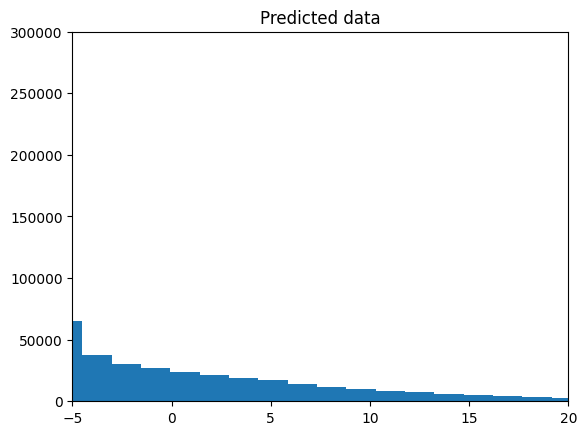

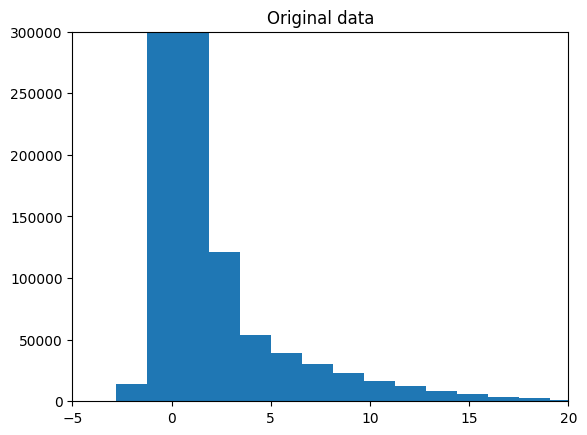

In [152]:
analyze_pred = 1
if analyze_pred:
    model_params['input_dim'] = trainer.train_loader.input_dim
    model_params['output_dim'] = trainer.train_loader.output_dim
    trainer.add_model(MLP, model_params)
    trainer.load_model(model_file)
    rna_pred, rna_orig = trainer.analyze_model(trainer.val_loader)
    #plot_model_analysis(rna_pred, rna_orig)

    plt.hist(rna_pred.flatten(), bins=100)
    plt.title('Predicted data')
    plt.ylim((0, 300000))
    plt.xlim((-5, 20))
    plt.show()
    plt.hist(rna_orig.flatten(), bins=100)
    plt.ylim((0, 300000))
    plt.xlim((-5, 20))
    plt.title('Original data')

## RUN LRRT

In [39]:
def run_lrrt(train_loader, val_loader, batch_size=2048, end_lr=10, min_lr=1e-7, wd=2e-2, validation=False, device='cuda'):
    def criterion(predicted, orig):
        loss_fn = nn.MSELoss()
        l = loss_fn(orig, predicted[0])
        return l

    #inputs = load_sparse_data(inputs_train_fn)
    #targets = load_sparse_data(targets_train_fn)
    #train_loader, val_loader = make_loaders(inputs, targets)
    
    model_inst = model(train_loader.input_dim, train_loader.output_dim)
    optimizer = torch.optim.AdamW(model_inst.parameters(), lr=min_lr, weight_decay=wd)
    lr_finder = LRFinder(model_inst, optimizer, criterion, device=device)
    if validation:
        lr_finder.range_test(train_loader, end_lr=end_lr, num_iter=100, val_loader=val_loader)
    else:
        lr_finder.range_test(train_loader, end_lr=end_lr, num_iter=100)
        
    lr_finder.plot(log_lr=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.04E-03


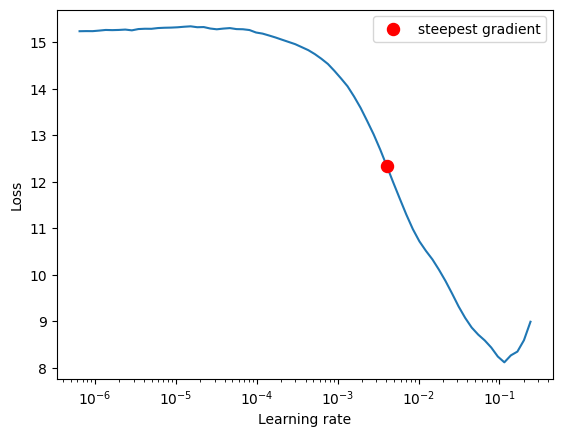

In [40]:
lrrt_on_train = 1
if lrrt_on_train:
    run_lrrt(train_loader, val_loader, end_lr=10)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.06E-04


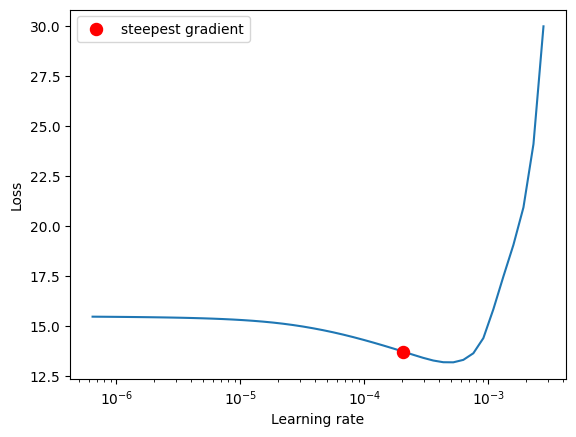

In [9]:
lrrt_on_val = 1
if lrrt_on_val:
    run_lrrt(train_loader, val_loader, validation=True)


In [13]:
inputs_test = load_sparse_data(inputs_test_fn)

## Make predictions

In [154]:
make_predictions = True
if make_predictions:
    model_params['input_dim'] = trainer.train_loader.input_dim
    model_params['output_dim'] = trainer.train_loader.output_dim
    trainer.add_model(model, model_params)
    trainer.load_model(model_file)
    
    
    outputs = trainer.transform(test_loader)

    with open(pred_file, 'wb') as f:
        np.save(f, outputs)